 
### Object 

Through this notebook, we will:

> 1. Practice building, evaluating, and finetuning a convolutional neural network on an image dataset from development to testing. 
> 2. Gain a deeper understanding of feature maps and filters by visualizing some from a pre-trained network. 


### Setup and resources 

Having a GPU will speed up the training process


This notebook will use a subset of images from Tiny ImageNet, which is a subset of the ImageNet dataset [https://image-net.org/]. Our subset of Tiny ImageNet contains 30 different categories, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total).





## Imports


In [1]:
!pip install natsort -qq
!pip install pytorchtools -qq

In [2]:
import cv2
import math

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.hub import load_state_dict_from_url

from PIL import Image
import matplotlib.pyplot as plt

import pandas as pd

from torch.utils.data import Dataset
from torchvision import datasets, transforms
import os
from natsort import natsorted
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm

import seaborn as sns

In [3]:
#paths 
train_path='../input/train-sets/train_set/'
mapping='../input/mapfile/mapping.txt'
test_path='../input/test-sets/test_set'

## Part 1: Single-batch training

We will use a method of architecture development called “single-batch training”, in which we cumulatively build a network architecture which can overfit a single training batch. A model which overfits performs very well on training data but generalises poorly on data it has not been trained on. If the model can easily overfit a single training batch, we know its architecture is complex enough to be able to learn the features present in the training data. Then we move on to training on the complete training set and adjust for the overfitting via regularisation.

### 1.1 Dataset class 

In [4]:
#to get the images paths and catagories
def get_ids(mapping):
  dictionary = {}
  dictionary_2={}
  dictionary['image_path'] = []
  x=(pd.read_csv(mapping,header=None,sep="\t")).drop(columns=[2])
  info=[]
  for i in range(30):
    info.append(os.path.join(train_path+x.iloc[i, 1]))
  for i in info:
    for filename in os.listdir(i):
      if filename.endswith(".JPEG"): 
        dictionary['image_path'].append(i+'/'+filename)
        dictionary_2[i+'/'+filename]=i.split('/')[-1]
      else:
        continue
  return dictionary,dictionary_2


In [5]:
dictionary,dictionary_2=get_ids(mapping)

In [6]:
#Converting catogires to numbers
data=(pd.read_csv(mapping,header=None,sep="\t")).drop(columns=[0,2])
dictionary_3=data.to_dict()
dictionary_3=dictionary_3[1]

In [7]:
def show_img(x): #show img
    x,y=next(iter(x))
    print(y[0])
    plt.imshow(x[0].permute(1,2,0))

In [8]:
class Data(Dataset):
  def __init__(self,ids,label,label_mapping,transform=None):
    self.ids=ids
    self.label=label
    self.label_mapping=label_mapping
    self.transform=transform
  def __len__(self):
    return len(self.ids)
  def __getitem__(self,index):
    img=Image.open(self.ids[index]).convert("RGB")
    #convert_tensor = transforms.ToTensor()
    #img=convert_tensor(img).permute(1,2,0)
    if self.transform is not None:
      img = self.transform(img)
    y_label=self.label[self.ids[index]]
    y_label=list(self.label_mapping.keys())[list(self.label_mapping.values()).index(y_label)]
    return (img,y_label)

In [9]:
def reading_data(dictionary_1,dictionary_2,dictionary_3,batch_size=64,transform=transforms.ToTensor()):
    
    dataset=Data(dictionary_1['image_path'],dictionary_2,dictionary_3,transform=transform)
    
    len_train= 10800  
    len_vald = 2700
    
    #splitting data
    train_set, vald_set = torch.utils.data.random_split(dataset, [len_train, len_vald])
    
    #DataLoaders
    train_loader= DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    vald_loader= DataLoader(dataset=vald_set, batch_size=batch_size, shuffle=True)

    return train_loader,vald_loader

### 1.2 Define 1-layer model 

Build a PyTorch model with the architecture defined below, which flattens the input image data into a 1-D tensor, and then uses a single fully connected layer as following: 

| Input channels  | Output channels | Layer type |
| --------------- | --------------- | ---------- |
| 3 x 128 x 128   | 30              | linear     |


In [10]:
# define a Model class
# model definition
class Model_1(nn.Module):
    # define model elements
    def __init__(self):
        super(Model_1, self).__init__()
        self.fc1 = nn.Linear(3*128*128,30)
    # forward propagate input
    def forward(self, x):
        x=x.reshape(x.shape[0],-1)
        x=self.fc1(x)
        return x

### 1.3 Single-batch training 

Train **one single batch** of training data and computes the loss on the complete validation set for each epoch as well. Set ```batch_size = 64```. Learning rate of 0.001 and an Adam optimizer. 

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size=64
num_epochs=50
learning_rate=0.001

In [12]:
transform_train=transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

In [13]:
#reading data
train_loader,vald_loader=reading_data(dictionary,dictionary_2,dictionary_3,batch_size=batch_size,transform=transform_train)

tensor(12)


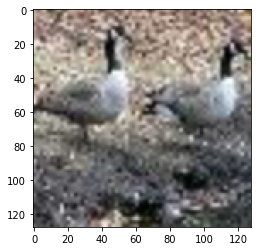

In [14]:
show_img(train_loader)

In [15]:
#Model instance
model_112=Model_1().to(device)
criterion=nn.CrossEntropyLoss()
optimizer= optim.Adam(model_112.parameters(),lr=learning_rate)

In [17]:
# Train batch model
def train_batch(model, device, train_loader, optimizer, epoch):
    
    model.train()
    
    batch= tqdm(next(iter(train_loader)))
    
    data,target=batch
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

In [18]:
# Accuracy check
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)    
            y = y.to(device=device)
            scores = model(x)
            
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
    
    model.train()
    
    return num_correct/num_samples

In [19]:
acc_batch_train=[]
acc_batch_vald=[]

for epoch in range(num_epochs):
    
    train_batch(model_112, device, train_loader, optimizer, epoch)
    
    train_acc=check_accuracy(train_loader, model_112)
    acc_batch_train.append(train_acc)
    vald_acc=check_accuracy(vald_loader, model_112)
    acc_batch_vald.append(vald_acc)

100%|██████████| 2/2 [00:00<00:00, 8405.42it/s]


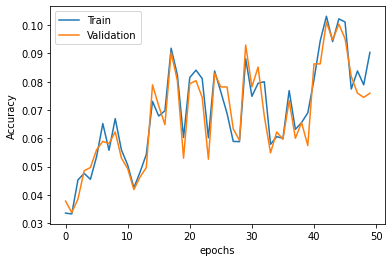

In [20]:
plt.plot(acc_batch_train)
plt.plot(acc_batch_vald)
plt.xlabel('epochs',)
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'])
plt.show()

### 1.4 CNN 

Creating a new model class by adding a combination of convolutional and fully connected layers, ReLU, and max-pool.

Comparing the graphs of the training and validation loss for the model with only one fully connected layer with the one with convolutional layers. 


In [21]:
class Model_2(nn.Module):
    # define model elements
    def __init__(self):
        super(Model_2, self).__init__()
        
        # Defining a 2D convolution layer # to be fixd

        self.conv1=nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.relu1=nn.ReLU(inplace=True)
        self.max1=nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2=nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.relu2=nn.ReLU(inplace=True)
        self.max2=nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3=nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu3=nn.ReLU(inplace=True)
        self.max3=nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4=nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu4=nn.ReLU(inplace=True)
        self.max4=nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv5=nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu5=nn.ReLU(inplace=True)
        self.max5=nn.MaxPool2d(kernel_size=2, stride=2)   
        
        self.l1=nn.Linear(128 * 4 * 4, 500)
        self.relu6=nn.ReLU(inplace=True)
        
        self.l2=nn.Linear(500, 200)
        self.relu7=nn.ReLU(inplace=True)
        
        self.l3=nn.Linear(200, 30)
        
        self.s1=nn.Sigmoid()
        
    # Defining the forward pass    
    def forward(self, x):
        x=self.max1(self.relu1(self.conv1(x)))
        x=self.max2(self.relu2(self.conv2(x)))
        x=self.max3(self.relu3(self.conv3(x)))
        x=self.max4(self.relu4(self.conv4(x)))
        x=self.max5(self.relu5(self.conv5(x)))
        
        x=x.reshape(x.shape[0],-1)
        
        x=self.relu6(self.l1(x))
        x=self.relu7(self.l2(x))
        x=self.l3(x)
        x=self.s1(x)
        
        return x

In [22]:
num_epochs=50
learning_rate=0.001

In [23]:
model_114= Model_2().to(device)
criterion= nn.CrossEntropyLoss()
optimizer= optim.Adam(model_114.parameters(),lr=learning_rate)

In [24]:
acc_cnn_batch_train=[]
acc_cnn_batch_vald=[]

for epoch in range(num_epochs):
    
    train_batch(model_114, device, train_loader, optimizer, epoch)
    
    train_acc=check_accuracy(train_loader, model_114)
    acc_cnn_batch_train.append(train_acc)
    
    vald_acc=check_accuracy(vald_loader, model_114)
    acc_cnn_batch_vald.append(vald_acc)

100%|██████████| 2/2 [00:00<00:00, 5932.54it/s]


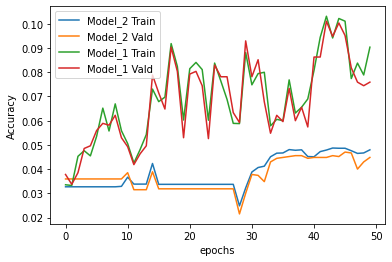

In [25]:
plt.plot(acc_cnn_batch_train)
plt.plot(acc_cnn_batch_vald)
plt.plot(acc_batch_train)
plt.plot(acc_batch_vald)
plt.xlabel('epochs',)
plt.ylabel('Accuracy')
plt.legend(['Model_2 Train','Model_2 Vald','Model_1 Train','Model_1 Vald'])
plt.show()

## Part 2: Training on complete dataset 

### 2.1 Train CNN 
Train the overfitting model ```model_114``` on the complete training dataset, and using the validation set to determine when to stop training.

Displaying the graph of training and validation loss over epochs to show how you determined the optimal number of training epochs.


In [26]:
model_114_early= Model_2().to(device)

In [32]:
batch_size = 64
num_epochs = 50
learning_rate=0.001
criterion= nn.CrossEntropyLoss()
optimizer= optim.Adam(model_114_early.parameters(),lr=learning_rate)

In [33]:
# to train the model
train_loss_e=[]
vald_loss_e=[]

def train_early(model, device, train_loader,vlad_loader, optimizer, epoch):
    
    model.train()
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss_e.append(loss.item())
       
    
    model.eval()
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(vald_loader)):
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            vald_loss_e.append(loss.item())
        
    return train_loss_e,vald_loss_e

In [34]:
acc_early_train=[]
acc_early_vald=[]
avg_train_losses=[]
avg_valid_losses=[]
best_loss=3.5
for epoch in range(1,num_epochs+1):
    
    train_losses,vald_losses = train_early(model_114_early, device, train_loader,vald_loader, optimizer, epoch)
    
    train_loss = np.average(train_losses)
    valid_loss = np.average(vald_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    
    train_acc=check_accuracy(train_loader, model_114_early)
    acc_early_train.append(train_acc)
    vald_acc=check_accuracy(vald_loader, model_114_early)
    acc_early_vald.append(vald_acc)
    
    epoch_len = len(str(num_epochs))

    print_msg = (f'[{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
    print(print_msg)
    if valid_loss > best_loss:
        best_loss = valid_loss
        
        print('early stop')
    
        break
    else:
        print('keep going')
    

100%|██████████| 43/43 [00:05<00:00,  7.91it/s]


[ 1/50] train_loss: 2.88465 valid_loss: 2.98563
keep going


100%|██████████| 43/43 [00:03<00:00, 12.94it/s]


[ 2/50] train_loss: 2.87833 valid_loss: 2.98366
keep going


100%|██████████| 43/43 [00:03<00:00, 12.94it/s]


[ 3/50] train_loss: 2.87310 valid_loss: 2.98618
keep going


100%|██████████| 43/43 [00:03<00:00, 12.56it/s]


[ 4/50] train_loss: 2.86820 valid_loss: 2.98518
keep going


100%|██████████| 43/43 [00:03<00:00, 12.44it/s]


[ 5/50] train_loss: 2.86299 valid_loss: 2.98410
keep going


100%|██████████| 43/43 [00:03<00:00, 12.82it/s]


[ 6/50] train_loss: 2.85865 valid_loss: 2.98314
keep going


100%|██████████| 43/43 [00:03<00:00, 13.34it/s]


[ 7/50] train_loss: 2.85352 valid_loss: 2.98275
keep going


100%|██████████| 43/43 [00:03<00:00, 12.92it/s]


[ 8/50] train_loss: 2.84983 valid_loss: 2.98402
keep going


100%|██████████| 43/43 [00:03<00:00, 13.12it/s]


[ 9/50] train_loss: 2.84576 valid_loss: 2.98418
keep going


100%|██████████| 43/43 [00:03<00:00, 13.41it/s]


[10/50] train_loss: 2.84130 valid_loss: 2.98283
keep going


100%|██████████| 43/43 [00:03<00:00, 12.49it/s]


[11/50] train_loss: 2.83789 valid_loss: 2.98322
keep going


100%|██████████| 43/43 [00:03<00:00, 12.08it/s]


[12/50] train_loss: 2.83355 valid_loss: 2.98241
keep going


100%|██████████| 43/43 [00:03<00:00, 13.44it/s]


[13/50] train_loss: 2.83022 valid_loss: 2.98198
keep going


100%|██████████| 43/43 [00:03<00:00, 13.40it/s]


[14/50] train_loss: 2.82637 valid_loss: 2.98088
keep going


100%|██████████| 43/43 [00:03<00:00, 13.25it/s]


[15/50] train_loss: 2.82252 valid_loss: 2.98099
keep going


100%|██████████| 43/43 [00:03<00:00, 13.52it/s]


[16/50] train_loss: 2.81874 valid_loss: 2.98159
keep going


100%|██████████| 43/43 [00:03<00:00, 12.77it/s]


[17/50] train_loss: 2.81519 valid_loss: 2.98152
keep going


100%|██████████| 43/43 [00:03<00:00, 12.51it/s]


[18/50] train_loss: 2.81179 valid_loss: 2.98217
keep going


100%|██████████| 43/43 [00:03<00:00, 13.34it/s]


[19/50] train_loss: 2.80893 valid_loss: 2.98167
keep going


100%|██████████| 43/43 [00:03<00:00, 12.92it/s]


[20/50] train_loss: 2.80553 valid_loss: 2.98191
keep going


100%|██████████| 43/43 [00:03<00:00, 10.93it/s]


[21/50] train_loss: 2.80237 valid_loss: 2.98170
keep going


100%|██████████| 43/43 [00:03<00:00, 13.20it/s]


[22/50] train_loss: 2.79932 valid_loss: 2.98156
keep going


100%|██████████| 43/43 [00:03<00:00, 11.94it/s]


[23/50] train_loss: 2.79643 valid_loss: 2.98150
keep going


100%|██████████| 43/43 [00:03<00:00, 12.03it/s]


[24/50] train_loss: 2.79362 valid_loss: 2.98137
keep going


100%|██████████| 43/43 [00:03<00:00, 12.60it/s]


[25/50] train_loss: 2.79068 valid_loss: 2.98196
keep going


100%|██████████| 43/43 [00:03<00:00, 13.04it/s]


[26/50] train_loss: 2.78803 valid_loss: 2.98212
keep going


100%|██████████| 43/43 [00:03<00:00, 12.92it/s]


[27/50] train_loss: 2.78535 valid_loss: 2.98249
keep going


100%|██████████| 43/43 [00:03<00:00, 12.04it/s]


[28/50] train_loss: 2.78279 valid_loss: 2.98250
keep going


100%|██████████| 43/43 [00:04<00:00, 10.74it/s]


[29/50] train_loss: 2.78049 valid_loss: 2.98288
keep going


100%|██████████| 43/43 [00:03<00:00, 13.12it/s]


[30/50] train_loss: 2.77845 valid_loss: 2.98318
keep going


100%|██████████| 43/43 [00:03<00:00, 13.00it/s]


[31/50] train_loss: 2.77611 valid_loss: 2.98344
keep going


100%|██████████| 43/43 [00:03<00:00, 12.73it/s]


[32/50] train_loss: 2.77386 valid_loss: 2.98367
keep going


100%|██████████| 43/43 [00:03<00:00, 12.40it/s]


[33/50] train_loss: 2.77165 valid_loss: 2.98365
keep going


100%|██████████| 43/43 [00:03<00:00, 12.52it/s]


[34/50] train_loss: 2.76955 valid_loss: 2.98370
keep going


100%|██████████| 43/43 [00:03<00:00, 13.18it/s]


[35/50] train_loss: 2.76775 valid_loss: 2.98392
keep going


100%|██████████| 43/43 [00:03<00:00, 12.87it/s]


[36/50] train_loss: 2.76590 valid_loss: 2.98407
keep going


100%|██████████| 43/43 [00:03<00:00, 13.07it/s]


[37/50] train_loss: 2.76416 valid_loss: 2.98450
keep going


100%|██████████| 43/43 [00:03<00:00, 12.05it/s]


[38/50] train_loss: 2.76246 valid_loss: 2.98456
keep going


100%|██████████| 43/43 [00:05<00:00,  7.54it/s]


[39/50] train_loss: 2.76069 valid_loss: 2.98479
keep going


100%|██████████| 43/43 [00:05<00:00,  7.49it/s]


[40/50] train_loss: 2.75891 valid_loss: 2.98496
keep going


100%|██████████| 43/43 [00:06<00:00,  7.03it/s]


[41/50] train_loss: 2.75704 valid_loss: 2.98531
keep going


100%|██████████| 43/43 [00:04<00:00,  9.15it/s]


[42/50] train_loss: 2.75537 valid_loss: 2.98556
keep going


100%|██████████| 43/43 [00:03<00:00, 12.49it/s]


[43/50] train_loss: 2.75373 valid_loss: 2.98588
keep going


100%|██████████| 43/43 [00:03<00:00, 12.47it/s]


[44/50] train_loss: 2.75224 valid_loss: 2.98617
keep going


100%|██████████| 43/43 [00:03<00:00, 12.79it/s]


[45/50] train_loss: 2.75064 valid_loss: 2.98652
keep going


100%|██████████| 43/43 [00:03<00:00, 13.07it/s]


[46/50] train_loss: 2.74931 valid_loss: 2.98665
keep going


100%|██████████| 43/43 [00:04<00:00, 10.74it/s]


[47/50] train_loss: 2.74782 valid_loss: 2.98701
keep going


100%|██████████| 43/43 [00:03<00:00, 12.28it/s]


[48/50] train_loss: 2.74638 valid_loss: 2.98705
keep going


100%|██████████| 43/43 [00:03<00:00, 12.96it/s]


[49/50] train_loss: 2.74521 valid_loss: 2.98731
keep going


100%|██████████| 43/43 [00:03<00:00, 13.13it/s]


[50/50] train_loss: 2.74408 valid_loss: 2.98711
keep going


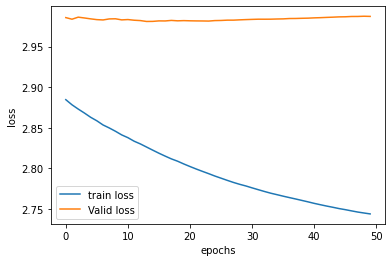

In [35]:
plt.plot(avg_train_losses)
plt.plot(avg_valid_losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train loss','Valid loss'])


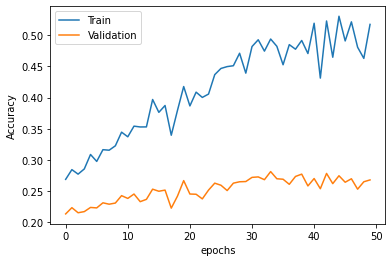

In [36]:
plt.plot(acc_early_train)
plt.plot(acc_early_vald)
plt.xlabel('epochs',)
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'])
plt.show()

### 2.2 Finetuning 

Finetuning the architecture by implementing 2 methods of reducing overfitting and increasing the model's ability to generalise.

**Method 1:** Data augmentation of your choice

In [37]:
# Train the model
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

In [38]:
def reading_data_transformed(dictionary_1,dictionary_2,dictionary_3,batch_size=64,transform=transforms.ToTensor()):
    
    dataset=Data(dictionary_1['image_path'],dictionary_2,dictionary_3,transform=transform)
    
    len_train= 10800  
    len_vald = 2700
    
    #splitting data
    train_set, vald_set = torch.utils.data.random_split(dataset, [len_train, len_vald])

    #DataLoaders
    train_loader= DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    vald_loader= DataLoader(dataset=vald_set, batch_size=batch_size, shuffle=True)

    return train_loader,vald_loader

In [39]:
def get_mean_std(loader):
    # var[X] = E[X**2] - E[X]**2
    channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

    for data, _ in tqdm(loader):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_sqrd_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [40]:
my_transforms = transforms.Compose(
    [ 
        transforms.Resize(128),
     # Perhaps a random rotation from -45 to 45 degrees
        transforms.RandomHorizontalFlip(p=0.5),  # Flips the image horizontally with probability 0.5
        transforms.RandomVerticalFlip(p=0.05),  # Flips image vertically with probability 0.05# Converts to grayscale with probability 0.2
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        
        # Finally converts PIL image to tensor so we can train w. pytorch # Note: these values aren't optimal
    ]
)

In [41]:
train_loader_trans,vald_loader_trans=reading_data_transformed(dictionary,dictionary_2,dictionary_3,batch_size=batch_size,transform=my_transforms)

tensor(6)


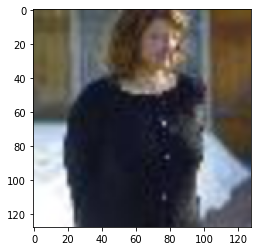

In [42]:
show_img(train_loader_trans)

In [43]:
model_122a = Model_2().to(device)

In [44]:

num_epochs=50
learning_rate=0.001
criterion=nn.CrossEntropyLoss()
optimizer= optim.Adam(model_122a.parameters(),lr=learning_rate)


In [45]:

model_122a_train=[]
model_122a_vald=[]


for epoch in range(num_epochs):
    
    train(model_122a, device, train_loader_trans, optimizer, epoch)
    
    train_acc=check_accuracy(train_loader_trans, model_122a)
    model_122a_train.append(train_acc)
    
    vald_acc=check_accuracy(vald_loader_trans, model_122a)
    model_122a_vald.append(vald_acc)

100%|██████████| 169/169 [00:13<00:00, 12.17it/s]


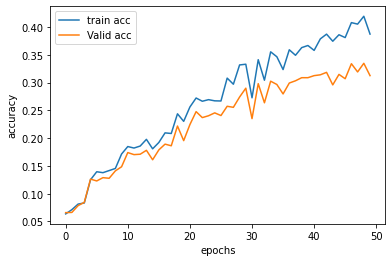

In [46]:
plt.plot(model_122a_train)
plt.plot(model_122a_vald)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train acc','Valid acc'])


**Method 2:** Adding dropout and/or batch normalisation to the model

In [47]:
class Model_3(nn.Module):
    # define model elements
    def __init__(self):
        super(Model_3, self).__init__()
        
        # Defining a 2D convolution layer # to be fixd

        self.conv1=nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.relu1=nn.ReLU(inplace=True)

        self.conv2=nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.relu2=nn.ReLU(inplace=True)

        self.max1=nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3=nn.Conv2d(16, 24, kernel_size=3, stride=1, padding=1)

        self.relu3=nn.ReLU(inplace=True)
        self.max2=nn.MaxPool2d(kernel_size=2, stride=2)

        self.l1=nn.Linear(24 * 32 * 32, 1000)
        self.l2=nn.Linear(1000, 500)
        self.l3=nn.Linear(500, 200)
        self.l4=nn.Linear(200, 30)
        
        self.dropout = nn.Dropout(0.25)
    # Defining the forward pass    
    def forward(self, x):
        x=self.conv1(x)
        x=self.relu1(x)
        x=self.conv2(x)
        x=self.relu2(x)
        x=self.max1(x)
        x=self.conv3(x)
        x=self.relu3(x)
        x=self.max2(x)
        
        x=x.reshape(x.shape[0],-1)
        
        x=self.l1(x)
        x=self.l2(x)
        x=self.l3(x)
        x=self.dropout(x)
        x=self.l4(x)
        return x

In [48]:
model_122b=Model_3().to(device)

In [49]:
batch_size=64
num_epochs=50
learning_rate=0.001

criterion=nn.CrossEntropyLoss()
optimizer= optim.Adam(model_122b.parameters(),lr=learning_rate)

In [50]:


model_122b_train=[]
model_122b_vald=[]

from tqdm import tqdm
x=train_loader
for epoch in range(num_epochs):
    
    train(model_122b, device, train_loader, optimizer, epoch)
    
    train_acc=check_accuracy(train_loader, model_122b)
    model_122b_train.append(train_acc)
    
    vald_acc=check_accuracy(vald_loader_trans, model_122b)
    model_122b_vald.append(vald_acc)

100%|██████████| 169/169 [00:13<00:00, 12.98it/s]


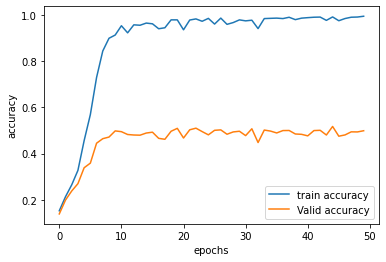

In [51]:
plt.plot(model_122b_train)
plt.plot(model_122b_vald)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train accuracy','Valid accuracy'])

### 2.3 Confusion matrices 

Generating two confusion matrices, one for the training set and one for the validation set

In [52]:
final_model= Model_2().to(device)

In [53]:
batch_size=64
num_epochs=25 #best epoch
learning_rate=0.001

criterion=nn.CrossEntropyLoss()
optimizer= optim.Adam(final_model.parameters(),lr=learning_rate)

In [54]:

for epoch in range(num_epochs):
    _,_ = train_early(final_model, device, train_loader_trans,vald_loader_trans, optimizer, epoch)

100%|██████████| 43/43 [00:03<00:00, 12.92it/s]


In [55]:
categories_names=(pd.read_csv(mapping,header=None,sep="\t")).drop(columns=[2])
categories_names=categories_names[1]

In [56]:
from sklearn.metrics import confusion_matrix
def conf_matrix(model,loader,categories_names):
    all_preds=torch.tensor([])
    all_labels=torch.tensor([])
    i=0
    with torch.no_grad():
        for batch in tqdm(loader):
            images,label=batch
            preds=model(images.to(device=device))
            
            all_preds=torch.cat((all_preds.to(device=device),preds.to(device=device)),dim=0)
            all_labels=torch.cat((all_labels.to(device=device),label.to(device=device)),dim=0)
            
        fig, ax = plt.subplots(figsize=(25,25))
        cm=confusion_matrix(all_labels.tolist(),all_preds.argmax(dim=1).tolist())
        conf_matrix=pd.DataFrame(data=cm,columns=categories_names
                                          ,index=categories_names)
        sns.heatmap(conf_matrix, annot=True, fmt="d",)
        
        plt.show()

100%|██████████| 169/169 [00:13<00:00, 12.64it/s]


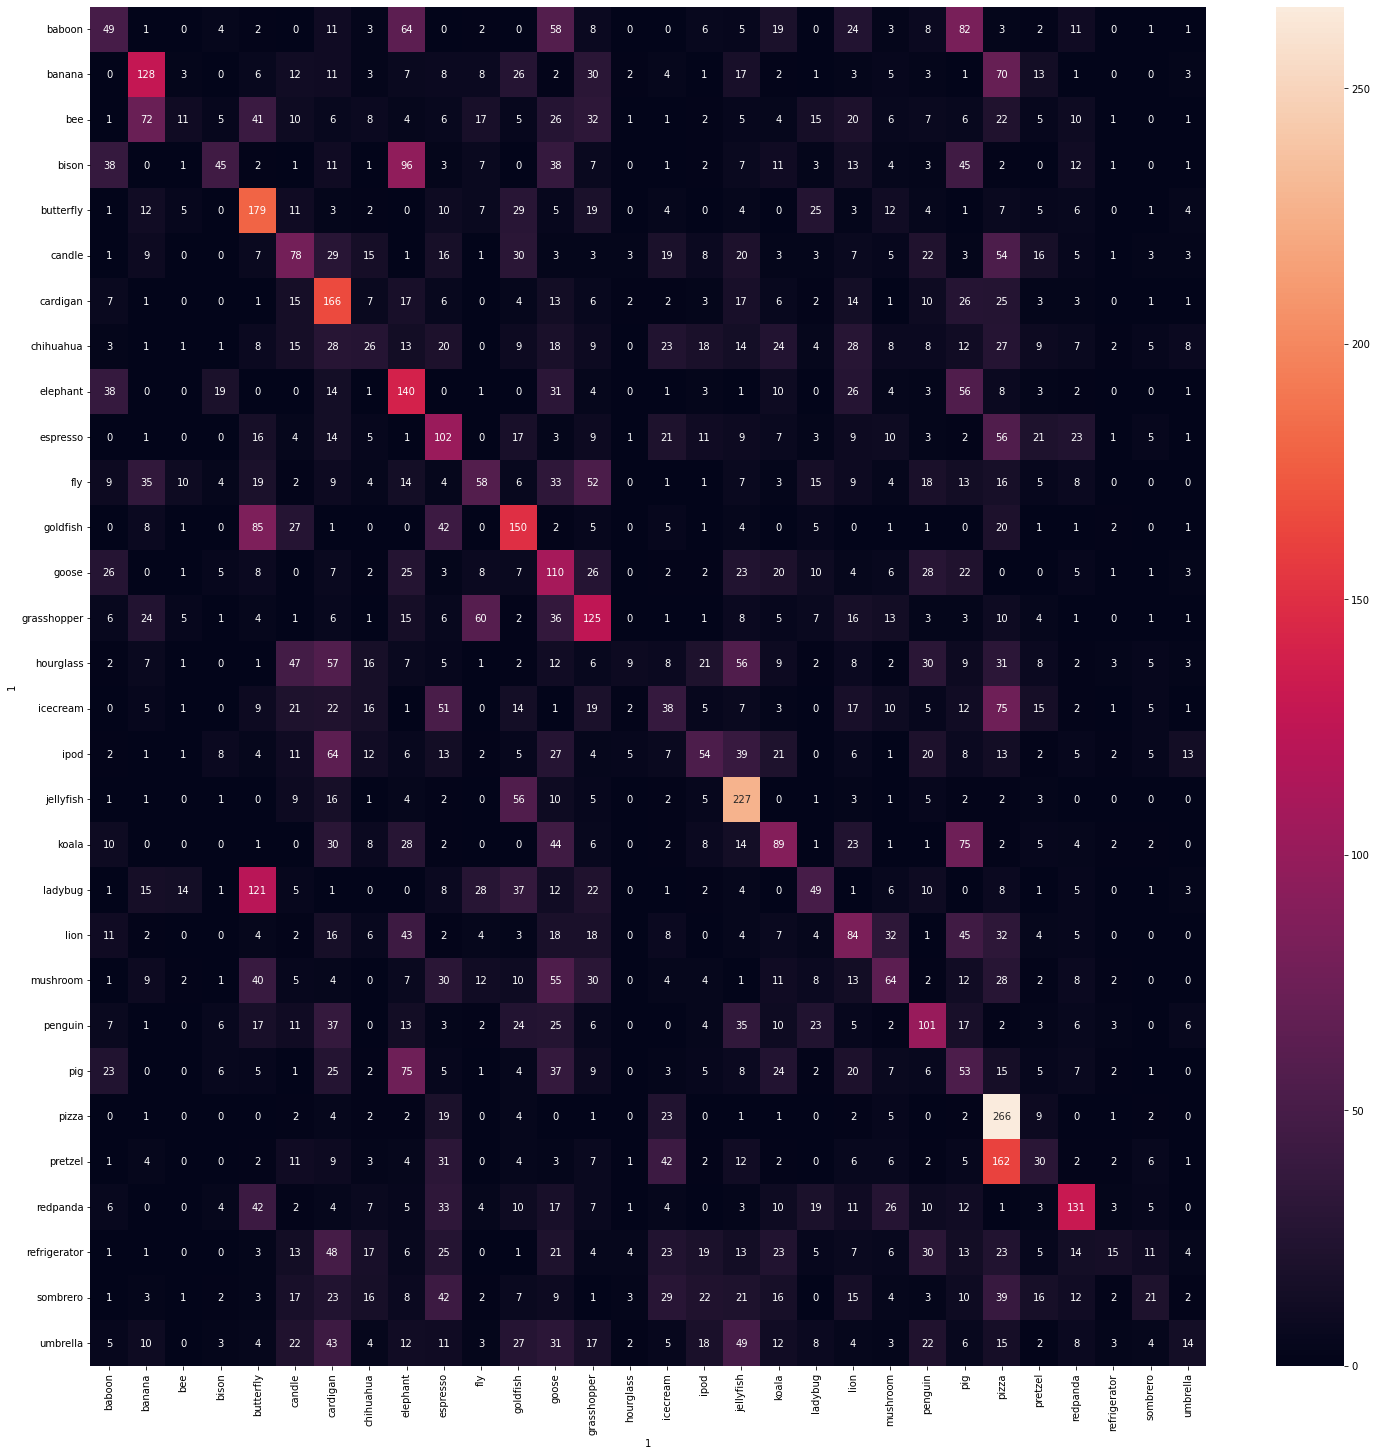

In [57]:
conf_matrix(final_model,train_loader_trans,categories_names)

100%|██████████| 43/43 [00:05<00:00,  7.24it/s]


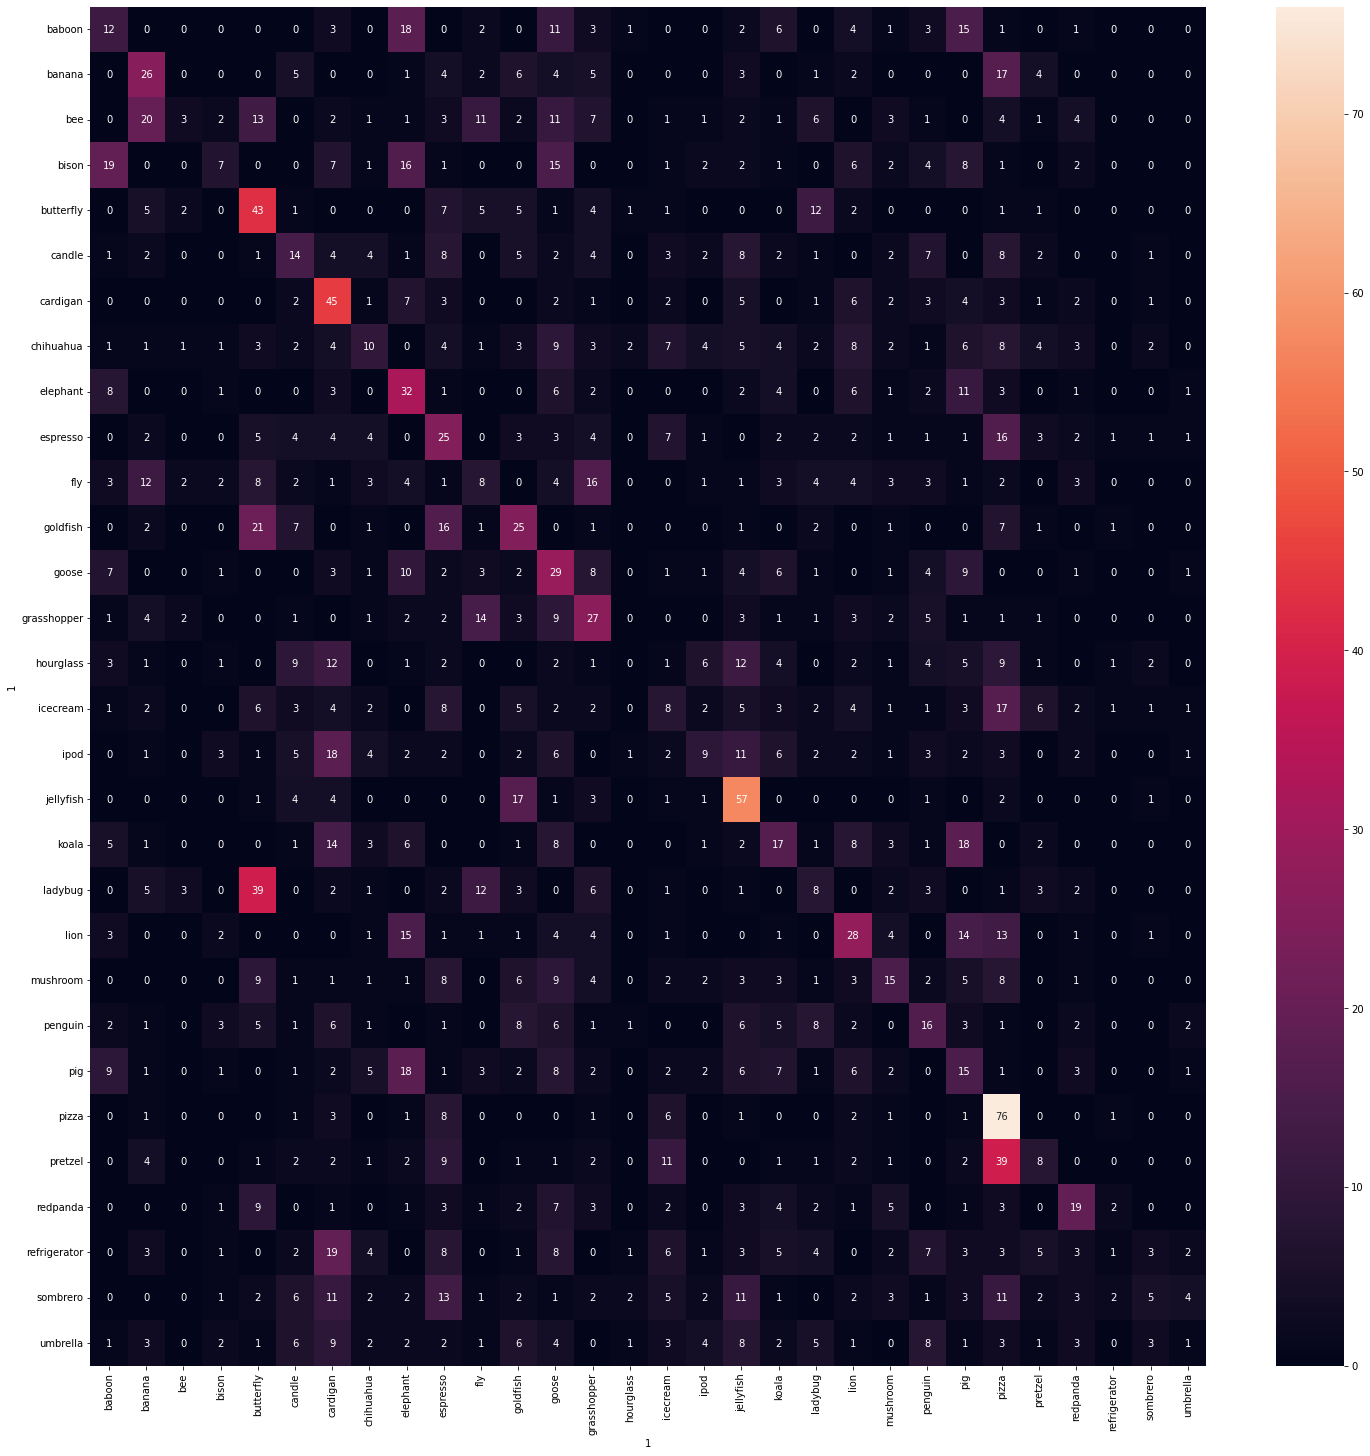

In [58]:
conf_matrix(final_model,vald_loader_trans,categories_names)

## Part 3: Testing on test data 

In [59]:
# TO COMPLETE
file_order=[]
class TestDataset(Dataset):
    def __init__(self, path, transform=None):
        self.images_name=os.listdir(test_path)
        images_paths=[]
        for i in range(len(self.images_name)):
            images_paths.append(os.path.join(test_path,self.images_name[i]))
            file_order.append(self.images_name[i])
        self.image_paths = images_paths
        self.transform = transform

    def __getitem__(self, index):
        x = Image.open(self.image_paths[index]).convert('RGB')
        if self.transform is not None:
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.image_paths)

In [60]:
def show_img_test(x): #show img
    x=next(iter(x))
    plt.imshow(x[0].permute(1,2,0))

In [61]:
trans_test=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()])

In [62]:
batch_size=1
test_dataset=TestDataset(test_path,transform=trans_test)
test_loader= DataLoader(dataset=test_dataset, batch_size=batch_size)

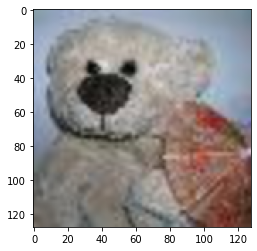

In [63]:

show_img_test(test_loader)

In [64]:

def predict_test(model,test_loader):
    classes=[]
    with torch.no_grad():
        model.eval()
        for data in tqdm(test_loader):
            
            pred=model(data.cuda())
            argmax=torch.argmax(pred)
            classes.append(argmax)
                
    return classes
            

In [65]:
output_class=predict_test(final_model,test_loader)

100%|██████████| 1500/1500 [00:08<00:00, 181.56it/s]


In [66]:
out2=[]
for i in output_class:
    out2.append(i.tolist())

In [67]:
# TO COMPLETE
df_out = pd.DataFrame(
    {'Id': file_order,
     'Category': out2,
    })

In [68]:
df_out.to_csv('output.csv',header=True,index=False)